# Urdu Caption Generation

# **Importing Libraries**

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
from nltk.translate.bleu_score import sentence_bleu
import cv2
from google.colab.patches import cv2_imshow

# **Mounting Google Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Downloading Dataset from Kaggle**

In [3]:
# Install Kaggle API
!pip install kaggle
import os
from google.colab import drive, files

# Upload kaggle.json file for Kaggle API authentication
uploaded = files.upload()

# Ensure .kaggle directory exists and move kaggle.json file there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#kaggle_dataset_url = 'adityajn105/flickr8k'
kaggle_dataset_url = 'hsankesara/flickr-image-dataset'


# Download the Kaggle dataset (but do not unzip)
!kaggle datasets download -d {kaggle_dataset_url}


"""
# Path to the folder where you want to save the zipped dataset in your Google Drive
save_dir = '/content/drive/MyDrive/DL-Project'

# Move the zipped file to the "DL Project" folder in Google Drive
!mv flickr-image-dataset.zip {save_dir}
"""

Saving kaggle.json to kaggle.json
100% 8.16G/8.16G [01:11<00:00, 183MB/s]
100% 8.16G/8.16G [01:11<00:00, 122MB/s]


'\n# Path to the folder where you want to save the zipped dataset in your Google Drive\nsave_dir = \'/content/drive/MyDrive/DL-Project\'\n\n# Move the zipped file to the "DL Project" folder in Google Drive\n!mv flickr-image-dataset.zip {save_dir}\n'

# **Unzipping Dataset (From Google Drive)**

In [4]:
%%capture
# unzipping Images
#!unzip "./gdrive/MyDrive/DL-Project/flickr8k.zip"
#!unzip "/content/drive/MyDrive/DL-Project/flickr-image-dataset.zip"
!unzip "/content/flickr-image-dataset.zip"


## **Loading Captions**

In [5]:
# Loading Captions
caption_file_path='/content/drive/MyDrive/DL-Project/captions_30k.json'

with open(caption_file_path, 'r') as j:
    data = json.load(j)

In [6]:
# Captions and image names are gotten from JSON file and stored in their respective arrays.
train_captions = []
image_filenames = []

for i in range(0,30000):
    for j in range(5):
        image_filenames.append(data['images'][i]['filename'][3:])
        train_captions.append('<start> '+str((data['images'][i]['sentences'][j]['raw']))+' <end>')


In [7]:
# Displaying some captions
train_captions[:10]

['<start>  گھنے بالوں والے دو نوجوان صحن میں گھومتے ہوئے اپنے ہاتھوں کو دیکھ رہے ہیں۔ <end>',
 '<start>  دو نوجوان، سفید نر باہر بہت سی جھاڑیوں کے قریب ہیں۔ <end>',
 '<start>  سبز قمیضوں میں دو آدمی صحن میں کھڑے ہیں۔ <end>',
 '<start>  نیلی قمیض پہنے ایک آدمی باغ میں کھڑا ہے۔ <end>',
 '<start>  دو دوست ایک ساتھ گزارے ہوئے وقت سے لطف اندوز ہوتے ہیں۔ <end>',
 '<start>  سخت ٹوپیاں پہنے کئی مرد ایک بڑا گھرنی نظام چلا رہے ہیں۔ <end>',
 '<start>  کارکن سامان کے ایک ٹکڑے کو اوپر سے نیچے دیکھ رہے ہیں۔ <end>',
 '<start>  دو آدمی سخت ٹوپیاں پہنے مشین پر کام کر رہے ہیں۔ <end>',
 '<start>  ایک اونچے ڈھانچے کے اوپر چار آدمی۔ <end>',
 '<start>  ایک بڑی رگ پر تین آدمی۔ <end>']

In [8]:
import pandas as pd
df = pd.DataFrame((image_filenames,train_captions)).T
df.columns = ['Images','Captions']
df

Images                                           Captions
0       1000092795.jpg  <start>  گھنے بالوں والے دو نوجوان صحن میں گھو...
1       1000092795.jpg  <start>  دو نوجوان، سفید نر باہر بہت سی جھاڑیو...
2       1000092795.jpg  <start>  سبز قمیضوں میں دو آدمی صحن میں کھڑے ہ...
3       1000092795.jpg  <start>  نیلی قمیض پہنے ایک آدمی باغ میں کھڑا ...
4       1000092795.jpg  <start>  دو دوست ایک ساتھ گزارے ہوئے وقت سے لط...
...                ...                                                ...
149995  7252718418.jpg  <start>  pigtails اور چشموں والی ایک پیاری سی ...
149996  7252718418.jpg  <start>  ایک نوجوان تماشے والی لڑکی فری اسٹینڈ...
149997  7252718418.jpg  <start>  ایک نوجوان سور کی دم والی لڑکی، ایک پ...
149998  7252718418.jpg  <start>  بیس بال کے میدان میں ایک چھوٹی لڑکی ٹ...
149999  7252718418.jpg  <start>  ایک چھوٹی سی لڑکی ٹی بال کھیل رہی ہے۔...

[150000 rows x 2 columns]

# **ResNet101 Feature Extraction Model**

In [9]:
# Loading ResNet-101-V2 model
# Removing fully connected layers
image_model = tf.keras.applications.ResNet101V2(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

171317808/171317808 [==============================] - 1s 0us/step


# **Loading and Preprocessing Images**

In [10]:
# loading and preprocessing images
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.resnet_v2.preprocess_input(img)
    return img, image_path

# **Extraction of Image Features**

In [11]:
# Compiling Dataset
encode_train = sorted(set(image_filenames))
encode_train = ['/content/flickr30k_images/flickr30k_images/' + filename for filename in encode_train]

print(encode_train)
import os
print(os.getcwd())

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

    """
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        # print(bf.numpy().shape)
        bf1 = bf.numpy()
        bf_truncated = bf1[:, :300]
        np.save(path_of_feature, bf_truncated)
    """

['/content/flickr30k_images/flickr30k_images/1000092795.jpg', '/content/flickr30k_images/flickr30k_images/10002456.jpg', '/content/flickr30k_images/flickr30k_images/1000268201.jpg', '/content/flickr30k_images/flickr30k_images/1000344755.jpg', '/content/flickr30k_images/flickr30k_images/1000366164.jpg', '/content/flickr30k_images/flickr30k_images/1000523639.jpg', '/content/flickr30k_images/flickr30k_images/1000919630.jpg', '/content/flickr30k_images/flickr30k_images/10010052.jpg', '/content/flickr30k_images/flickr30k_images/1001465944.jpg', '/content/flickr30k_images/flickr30k_images/1001545525.jpg', '/content/flickr30k_images/flickr30k_images/1001573224.jpg', '/content/flickr30k_images/flickr30k_images/1001633352.jpg', '/content/flickr30k_images/flickr30k_images/1001773457.jpg', '/content/flickr30k_images/flickr30k_images/1001896054.jpg', '/content/flickr30k_images/flickr30k_images/100197432.jpg', '/content/flickr30k_images/flickr30k_images/100207720.jpg', '/content/flickr30k_images/fl

In [12]:
# the .npy file is loaded
npy_path = '/content/flickr30k_images/flickr30k_images/1000092795.jpg.npy'
npy_data = np.load(npy_path)

# it is onverted to a TensorFlow tensor
img_tensor = tf.convert_to_tensor(npy_data, dtype=tf.float32)

# If needed, the tensor can also be normalized or preprocess
print(img_tensor.shape)

(100, 2048)


Saving Extracted Features to Drive

In [ ]:
#!cp -r /content/flickr30k_images /content/drive/MyDrive/DL-Project

In [13]:
print(image_filenames)

['1000092795.jpg', '1000092795.jpg', '1000092795.jpg', '1000092795.jpg', '1000092795.jpg', '10002456.jpg', '10002456.jpg', '10002456.jpg', '10002456.jpg', '10002456.jpg', '1000268201.jpg', '1000268201.jpg', '1000268201.jpg', '1000268201.jpg', '1000268201.jpg', '1000344755.jpg', '1000344755.jpg', '1000344755.jpg', '1000344755.jpg', '1000344755.jpg', '1000366164.jpg', '1000366164.jpg', '1000366164.jpg', '1000366164.jpg', '1000366164.jpg', '1000523639.jpg', '1000523639.jpg', '1000523639.jpg', '1000523639.jpg', '1000523639.jpg', '1000919630.jpg', '1000919630.jpg', '1000919630.jpg', '1000919630.jpg', '1000919630.jpg', '10010052.jpg', '10010052.jpg', '10010052.jpg', '10010052.jpg', '10010052.jpg', '1001465944.jpg', '1001465944.jpg', '1001465944.jpg', '1001465944.jpg', '1001465944.jpg', '1001545525.jpg', '1001545525.jpg', '1001545525.jpg', '1001545525.jpg', '1001545525.jpg', '1001573224.jpg', '1001573224.jpg', '1001573224.jpg', '1001573224.jpg', '1001573224.jpg', '1001633352.jpg', '1001633352

# **Preprocessing of Captions**

In [14]:
# Find the maximum length of caption in dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [15]:
# Choose the top k words from the vocabulary
top_k = 10000
# Tokeninzation
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
# Converting into to sequences
train_seqs = tokenizer.texts_to_sequences(train_captions)
print("Before: ",train_captions[0])
print("After: ",train_seqs[0])

Before:  <start>  گھنے بالوں والے دو نوجوان صحن میں گھومتے ہوئے اپنے ہاتھوں کو دیکھ رہے ہیں۔ <end>
After:  [2, 3757, 66, 59, 20, 29, 447, 7, 1669, 25, 33, 506, 23, 30, 15, 11, 3]


In [16]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [17]:
# Padding each vector to the max_length of the captions
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [18]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

# **Splitting Data into Training and Validation**

In [19]:
# Splitting data into training and validaiton
img_name_train, img_name_val, cap_train, cap_val = train_test_split(image_filenames,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [20]:
print(img_name_train)
print(img_name_val)

['6475050767.jpg', '4718840212.jpg', '2344186101.jpg', '6760463415.jpg', '1280147517.jpg', '5536289343.jpg', '4533759725.jpg', '135200870.jpg', '5797618847.jpg', '2035511078.jpg', '2837804631.jpg', '4870291079.jpg', '3759993037.jpg', '6907002468.jpg', '461139067.jpg', '3376227992.jpg', '3585598356.jpg', '2915400809.jpg', '269440642.jpg', '4928592495.jpg', '3111208043.jpg', '6651304481.jpg', '6360761183.jpg', '3504479370.jpg', '2269021076.jpg', '480653124.jpg', '117883760.jpg', '2502354602.jpg', '688210930.jpg', '3506869953.jpg', '294111300.jpg', '3962553148.jpg', '1362987900.jpg', '1974820694.jpg', '2888499869.jpg', '3266261886.jpg', '3470711198.jpg', '1616220830.jpg', '1131056918.jpg', '397982550.jpg', '2908834379.jpg', '2946354846.jpg', '59209034.jpg', '6666394813.jpg', '2230813326.jpg', '4612021294.jpg', '3675685612.jpg', '6843047255.jpg', '2570559405.jpg', '20450474.jpg', '4579086425.jpg', '3414953159.jpg', '124880336.jpg', '3031093209.jpg', '4878557563.jpg', '3720645102.jpg', '713

In [21]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(120000, 120000, 30000, 30000)

# **Encoder - Decoder Architecture**

In [22]:
SIZE_OF_BATCH = 64
BUFFER_SIZE = 10
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // SIZE_OF_BATCH
features_shape = 2048
attention_features_shape = 100

In [23]:
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

img_name_train = ['/content/flickr30k_images/flickr30k_images/' + filename for filename in img_name_train]
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.shuffle(BUFFER_SIZE).batch(SIZE_OF_BATCH)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [24]:
print(img_name_train)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# **Attention Mechanism**

In [25]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):

    hidden_with_time_axis = tf.expand_dims(hidden, 1)
    # alignment score = tanh(X_E.W_E + H_D.W_D)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
    # attention weights = softmax(alignment scores)
    attention_weights = tf.nn.softmax(self.V(score), axis=1)
    # context vector = attention weights * extracted features
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

# **CNN Encoder**

In [26]:
# Extract image features
class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

# **RNN Decoder**

In [27]:
# Inputs extracted features
# Pass these features and previous hidden layer to attention mechnism
# Attention mechanism returns context vector and attention weights
# after concatenating context vector with current input of decoder
# GRU then predict next wrod
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):

    context_vector, attention_weights = self.attention(features, hidden)
    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    output, state = self.gru(x)
    x = self.fc1(output)
    x = tf.reshape(x, (-1, x.shape[2]))
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, size_of_batch):
    return tf.zeros((size_of_batch, self.units))

In [28]:
# initializing encoder and decoder
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

# **Hyperparameters for Training**

In [29]:
# Setting Optimizer and Loss Function
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [30]:
  #checkpoint_path = "/content/drive/MyDrive/DL-Project/Checkpoints"
  checkpoint_path = "/content/drive/MyDrive/DL-Project/Checkpoints-25K"
  ckpt = tf.train.Checkpoint(encoder=encoder,
                            decoder=decoder,
                            optimizer = optimizer)
  ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [31]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  ckpt.restore(ckpt_manager.latest_checkpoint)

# **Training Using Gradient Accumulation Approach**

In [ ]:
"""import time
from tensorflow.keras.metrics import Accuracy

# Number of steps to accumulate gradients
accumulation_steps = 100

# Initialize accumulation variables
accumulated_gradients = [tf.Variable(tf.zeros_like(tv), trainable=False) for tv in encoder.trainable_variables + decoder.trainable_variables]

@tf.function
def train_step(img_tensor, target, apply_gradients):
    loss = 0
    all_predictions = []

    hidden = decoder.reset_state(size_of_batch=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            all_predictions.append(predictions)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)

    all_predictions = tf.stack(all_predictions, axis=1)
    total_loss = (loss / int(target.shape[1]))

    gradients = tape.gradient(loss, encoder.trainable_variables + decoder.trainable_variables)

    # Accumulate gradients
    for accum_grad, grad in zip(accumulated_gradients, gradients):
        accum_grad.assign_add(grad)

    if apply_gradients:
        optimizer.apply_gradients(zip(accumulated_gradients, encoder.trainable_variables + decoder.trainable_variables))
        for accum_grad in accumulated_gradients:
            accum_grad.assign(tf.zeros_like(accum_grad))

    return loss, total_loss, all_predictions

"""

"import time\nfrom tensorflow.keras.metrics import Accuracy\n\n# Number of steps to accumulate gradients\naccumulation_steps = 100\n\n# Initialize accumulation variables\naccumulated_gradients = [tf.Variable(tf.zeros_like(tv), trainable=False) for tv in encoder.trainable_variables + decoder.trainable_variables]\n\n@tf.function\ndef train_step(img_tensor, target, apply_gradients):\n    loss = 0\n    all_predictions = []\n\n    hidden = decoder.reset_state(size_of_batch=target.shape[0])\n    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)\n\n    with tf.GradientTape() as tape:\n        features = encoder(img_tensor)\n        for i in range(1, target.shape[1]):\n            predictions, hidden, _ = decoder(dec_input, features, hidden)\n            all_predictions.append(predictions)\n            loss += loss_function(target[:, i], predictions)\n            dec_input = tf.expand_dims(target[:, i], 1)\n\n    all_predictions = tf.stack(all_predictions, axis

In [ ]:
"""NUM_EPOCHS = 5
loss_plot = []
accuracy_metric = Accuracy()

for epoch in range(NUM_EPOCHS):
    start = time.time()
    total_loss = 0
    accuracy_metric.reset_states()

    batch_count = 0
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_count += 1
        apply_gradients = batch_count % accumulation_steps == 0 or batch == len(dataset) - 1
        batch_loss, t_loss, predictions = train_step(img_tensor, target, apply_gradients)
        total_loss += t_loss

        # Update accuracy

        target_aligned = target[:, :-1]
        predictions_max = tf.argmax(predictions, axis=-1)
        accuracy_metric.update_state(target_aligned, predictions_max)


        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f} '.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])
              ))

        # Reset accumulated gradients after they are applied
        if apply_gradients:
            for accum_grad in accumulated_gradients:
                accum_grad.assign(tf.zeros_like(accum_grad))

    # Record the average loss and accuracy for the epoch
    loss_plot.append(total_loss / len(dataset))
    epoch_accuracy = accuracy_metric.result().numpy()

    # Save the model every 5 epochs
    if epoch % 2 == 0:
        ckpt_manager.save()

    print ('Epoch {} Loss {:.6f} '.format(epoch + 1,
                                          total_loss / len(dataset),
                                          ))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
"""

"NUM_EPOCHS = 5\nloss_plot = []\naccuracy_metric = Accuracy()\n\nfor epoch in range(NUM_EPOCHS):\n    start = time.time()\n    total_loss = 0\n    accuracy_metric.reset_states()\n\n    batch_count = 0\n    for (batch, (img_tensor, target)) in enumerate(dataset):\n        batch_count += 1\n        apply_gradients = batch_count % accumulation_steps == 0 or batch == len(dataset) - 1\n        batch_loss, t_loss, predictions = train_step(img_tensor, target, apply_gradients)\n        total_loss += t_loss\n\n        # Update accuracy\n        \n        target_aligned = target[:, :-1]\n        predictions_max = tf.argmax(predictions, axis=-1)\n        accuracy_metric.update_state(target_aligned, predictions_max)\n        \n\n        if batch % 100 == 0:\n            print ('Epoch {} Batch {} Loss {:.4f} '.format(\n              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])\n              ))\n\n        # Reset accumulated gradients after they are applied\n        if apply_gradient

# **Training**

In [32]:
# Training Function
@tf.function
def train_step(img_tensor, target):
  loss = 0
  all_predictions = []


  # Initiating hidden state for first time
  hidden = decoder.reset_state(size_of_batch=target.shape[0])
  # current input to decoder
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      # Extracting features from encoder
      features = encoder(img_tensor)
      for i in range(1, target.shape[1]):
          # Passing features, previous hidden state and input to the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          all_predictions.append(predictions)

          # calculating loss
          loss += loss_function(target[:, i], predictions)
          dec_input = tf.expand_dims(target[:, i], 1)

  all_predictions = tf.stack(all_predictions, axis=1)

  total_loss = (loss / int(target.shape[1]))
  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss, all_predictions

In [ ]:
from tensorflow.keras.metrics import Accuracy
import gc

NUM_EPOCHS = 20
loss_plot = []
accuracy_metric = Accuracy()

for epoch in range(start_epoch, NUM_EPOCHS):
    start = time.time()
    total_loss = 0
    accuracy_metric.reset_states()

    # Iterate over the batches of the dataset.
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss, predictions = train_step(img_tensor, target)
        total_loss += t_loss

        # Update accuracy - Replace 'predictions' with your model's predictions
        # and 'target' with the correct labels
        """
        target_aligned = target[:, :-1]
        predictions_max = tf.argmax(predictions, axis=-1)
        accuracy_metric.update_state(target_aligned, predictions_max)
        """

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f} '.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])
              ))

    # Record the average loss and accuracy for the epoch.
    loss_plot.append(total_loss / num_steps)
    epoch_accuracy = accuracy_metric.result().numpy()

    ckpt_manager.save()
    """# Save the model every 5 epochs
    if epoch % 2 == 0:
        ckpt_manager.save()"""

    print ('Epoch {} Loss {:.6f} '.format(epoch + 1,
                                          total_loss/num_steps,
                                          ))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    gc.collect()


Epoch 1 Batch 0 Loss 1.3927 
Epoch 1 Batch 100 Loss 0.7634 
Epoch 1 Batch 200 Loss 0.7500 
Epoch 1 Batch 300 Loss 0.5935 
Epoch 1 Batch 400 Loss 0.6045 
Epoch 1 Batch 500 Loss 0.5934 
Epoch 1 Batch 600 Loss 0.5436 
Epoch 1 Batch 700 Loss 0.5581 
Epoch 1 Batch 800 Loss 0.5278 
Epoch 1 Batch 900 Loss 0.6082 
Epoch 1 Batch 1000 Loss 0.5254 
Epoch 1 Batch 1100 Loss 0.4872 
Epoch 1 Batch 1200 Loss 0.4151 
Epoch 1 Batch 1300 Loss 0.4972 
Epoch 1 Batch 1400 Loss 0.4496 
Epoch 1 Batch 1500 Loss 0.5004 
Epoch 1 Batch 1600 Loss 0.4282 
Epoch 1 Batch 1700 Loss 0.4977 
Epoch 1 Batch 1800 Loss 0.5331 
Epoch 1 Loss 0.552569 
Time taken for 1 epoch 959.8088793754578 sec

Epoch 2 Batch 0 Loss 0.4858 
Epoch 2 Batch 100 Loss 0.4220 
Epoch 2 Batch 200 Loss 0.5103 
Epoch 2 Batch 300 Loss 0.4573 
Epoch 2 Batch 400 Loss 0.4539 
Epoch 2 Batch 500 Loss 0.4795 
Epoch 2 Batch 600 Loss 0.4654 
Epoch 2 Batch 700 Loss 0.4805 
Epoch 2 Batch 800 Loss 0.4634 
Epoch 2 Batch 900 Loss 0.5201 
Epoch 2 Batch 1000 Loss 0.4

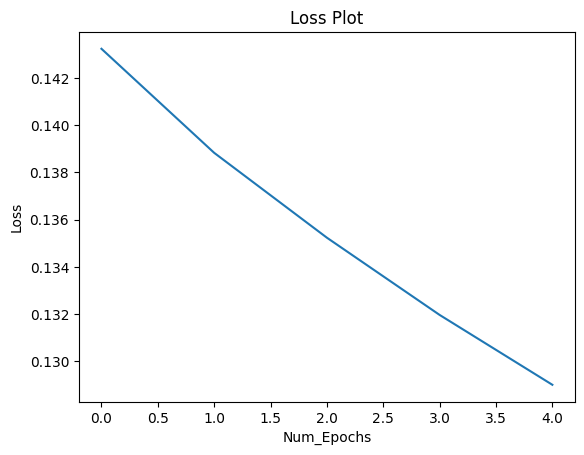

In [ ]:
# Loss curve
plt.plot(loss_plot)
plt.xlabel('Num_Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

# **Evaluation**

In [50]:
# This function generate captions on evaluation data
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))
    hidden = decoder.reset_state(size_of_batch=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)

    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()

        result.append(tokenizer.index_word[predicted_id])
        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot
        dec_input = tf.expand_dims([predicted_id], 0)


    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [30]:
# This function is used to plot attentions
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [ ]:
print(img_name_train)
print(" *************\n")
print(img_name_val)

['/content/flickr30k_images/flickr30k_images/118939364.jpg', '/content/flickr30k_images/flickr30k_images/122156386.jpg', '/content/flickr30k_images/flickr30k_images/105223874.jpg', '/content/flickr30k_images/flickr30k_images/101093029.jpg', '/content/flickr30k_images/flickr30k_images/1088767354.jpg', '/content/flickr30k_images/flickr30k_images/128452798.jpg', '/content/flickr30k_images/flickr30k_images/1297871927.jpg', '/content/flickr30k_images/flickr30k_images/1094606832.jpg', '/content/flickr30k_images/flickr30k_images/1040426962.jpg', '/content/flickr30k_images/flickr30k_images/12393802.jpg', '/content/flickr30k_images/flickr30k_images/127450902.jpg', '/content/flickr30k_images/flickr30k_images/12736326.jpg', '/content/flickr30k_images/flickr30k_images/112178718.jpg', '/content/flickr30k_images/flickr30k_images/1097710887.jpg', '/content/flickr30k_images/flickr30k_images/10082348.jpg', '/content/flickr30k_images/flickr30k_images/1083240835.jpg', '/content/flickr30k_images/flickr30k

['<start>  دو نوعمر لڑکیاں ایک صحن میں کود رہی ہیں، جس کے پس منظر میں دو منزلہ بھوری عمارت ہے، ایک دوسرے کا دایاں ہاتھ پکڑے ہوئے ہیں۔ <end>', '<start>  دو نوجوان نوعمر لڑکیاں، دونوں جینز پہنے ہوئے ہیں، ہاتھ پکڑے ہوئے ہیں اور ساتھ ہی گھاس والے علاقے میں ہوا میں چھلانگ لگا رہی ہیں۔ <end>', '<start>  دو سفید فام نوعمر لڑکیاں ہاتھ پکڑے ہوا میں چھلانگ لگا رہی ہیں۔ <end>', '<start>  چھلانگ لگاتے ہوئے دو خواتین ہاتھ ہوا میں پکڑے ہوئے ہیں۔ <end>', '<start>  دو لڑکیاں ہوا کے وسط میں ہاتھ ہلا رہی ہیں۔ <end>']
1184440714.jpg


<ipython-input-30-55c3ae4dac28>:15: UserWarning: Glyph 1729 (\N{ARABIC LETTER HEH GOAL}) missing from current font.
  plt.tight_layout()
<ipython-input-30-55c3ae4dac28>:15: UserWarning: Matplotlib currently does not support Arabic natively.
  plt.tight_layout()
<ipython-input-30-55c3ae4dac28>:15: UserWarning: Glyph 1746 (\N{ARABIC LETTER YEH BARREE}) missing from current font.
  plt.tight_layout()
<ipython-input-30-55c3ae4dac28>:15: UserWarning: Glyph 1748 (\N{ARABIC FULL STOP}) missing from current font.
  plt.tight_layout()


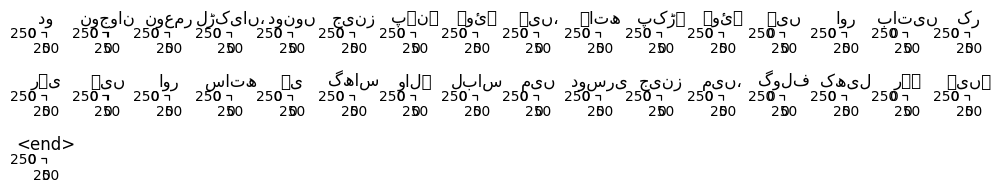

Prediction Caption: دو نوجوان نوعمر لڑکیاں، دونوں جینز پہنے ہوئے ہیں، ہاتھ پکڑے ہوئے ہیں اور باتیں کر رہی ہیں اور ساتھ ہی گھاس والے لباس میں دوسری جینز میں، گولف کھیل رہے ہیں۔ <end>
BLEU Score: 0.7400074343995757


In [54]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
img_name_val2 = ['/content/flickr30k_images/flickr30k_images/' + filename for filename in img_name_val]
image = img_name_val2[rid]
result, attention_plot = evaluate(image)
filename = os.path.basename(img_name_val2[rid])
real = list(df[df['Images']==filename]['Captions'])
print(real)
print(filename)

plot_attention(image, result, attention_plot)


cleaned = []
for i in range(len(real)):
    cleaned.append(real[i][7:-5])
predicted = ' '.join(result)

print ('Prediction Caption:', predicted)
#bs = sentence_bleu(cleaned, predicted)


"""
# predicted caption is tokenized
predicted_tokens = predicted.split()
print("Tokenized Prediction:", predicted_tokens)

# Actual caption is tokenized
cleaned_tokens = [ref.split() for ref in cleaned]
print("Tokenized Actual Captions:", cleaned_tokens)
"""

# BLEU score is calculated
bs =  sentence_bleu(cleaned, predicted)
print('BLEU Score:', bs)


In [53]:
#Testing images from the Validation

score = 0
for i in range (0,len(img_name_val),5):
    image = img_name_val2[i]
    result, attention_plot = evaluate(image)
    filename = os.path.basename(img_name_val2[i])
    real = list(df[df['Images']==filename]['Captions'])

    cleaned = []
    for i in range(len(real)):
        cleaned.append(real[i][7:-5])
    predicted = ' '.join(result)
    predicted_tokens = predicted.split()
    score += sentence_bleu(cleaned, predicted)

    bs = sentence_bleu(cleaned, predicted)
    print('BLEU Score:', bs)

val_bleu = score/len(img_name_val)*5
print("BLEU score on validation data: ",val_bleu)


BLEU Score: 0.8170465516951693
BLEU Score: 0.8608486937308775
BLEU Score: 0.9319564676450208
BLEU Score: 0.32356805847028486
BLEU Score: 0.649133265782635
BLEU Score: 0.8074023177148895
BLEU Score: 0.7133640759767814
BLEU Score: 0.60247260951712
BLEU Score: 0.8155224183994135
BLEU Score: 0.9083975007404717
BLEU Score: 0.7885992276978401
BLEU Score: 0.88279972422601
BLEU Score: 0.6673133662527511
BLEU Score: 0.5004713645592511
BLEU Score: 0.848334605514672
BLEU Score: 0.727848999109804
BLEU Score: 0.9109659295135636
BLEU Score: 0.6366389931351489
BLEU Score: 0.6664945018472065
BLEU Score: 0.7669495831899548
BLEU Score: 0.9224563371351328
BLEU Score: 0.4133030061223021
BLEU Score: 0.7142212598161487
BLEU Score: 0.6208993109743981
BLEU Score: 0.8794245150375142
BLEU Score: 0.8394577145582771
BLEU Score: 0.95121355843059
BLEU Score: 0.8989354241697113
BLEU Score: 0.8609447479560312
BLEU Score: 0.8946750330953485
BLEU Score: 0.6633300249357247
BLEU Score: 0.914855465984461
BLEU Score: 0.889

KeyboardInterrupt: ignored

# **Inference**

### **Image 01**

64400/64400 [==============================] - 0s 4us/step
Prediction Caption: دھاری دار کتا پانی میں ملا رہا ہے۔ <end>


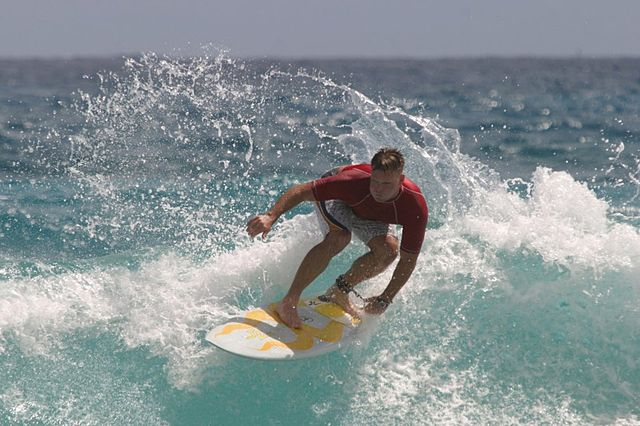

In [ ]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-8:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
Image.open(image_path)

### **Image 02**

Prediction Caption: ٹوپی میں ملبوس ایک آدمی نارنجی رنگ کی قمیض میں عورت الیکٹرک مکسر پکڑے ہوئے ہے۔ <end>


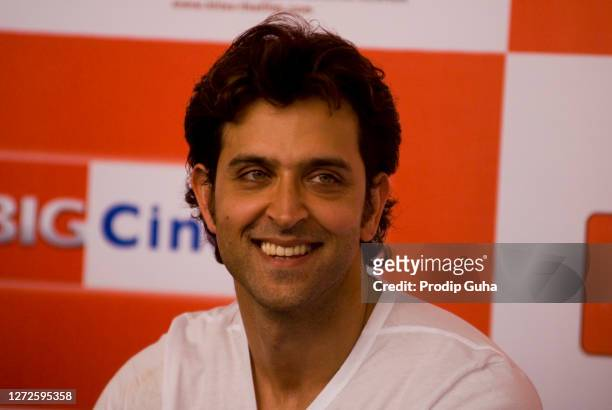

In [ ]:
image_url = 'https://media.gettyimages.com/id/1272595358/photo/entertainment-india-2010.jpg?s=612x612&w=gi&k=20&c=KAXZCOk561VKp96nOGZDml05lCwigqYflOfXajv13XY='
image_extension = image_url[-18:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)
#image_path = tf.keras.utils.get_file('image', origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
Image.open(image_path)

### **Image 03**

Prediction Caption: سنہرے بالوں والا نوجوان میں ایک کتاب کے ساتھ بستر پر بیٹھی ہے۔ <end>


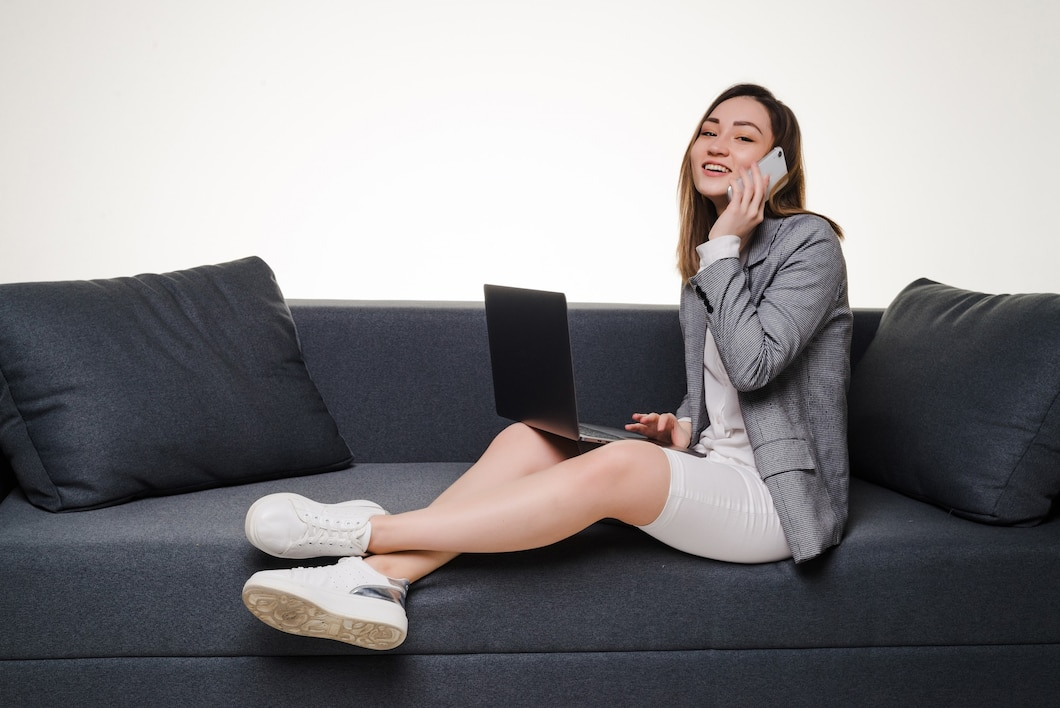

In [ ]:
image_url = 'https://img.freepik.com/free-photo/asian-woman-phone-using-laptop-home-living-room-working-from-home-quarantine-lockdown_231208-10814.jpg?w=1060&t=st=1703419321~exp=1703419921~hmac=7c24b9bae4df101c24b438c37f38364949808d17c15ab4a8182b7b958c3787cc'
image_extension = image_url[-18:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)
#image_path = tf.keras.utils.get_file('image', origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
Image.open(image_path)

# **Image 04**

Prediction Caption: ایک پارک میں ایک بچے کو ایک دوسرے سے گھرے ہوئے ایک گروپ ایک موڑ کے گرد دھکیل رہے ہیں۔ <end>


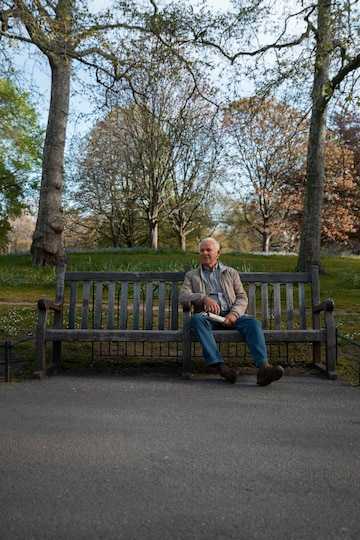

In [ ]:
image_url = 'https://img.freepik.com/free-photo/full-shot-old-man-sitting-bench_23-2150493049.jpg?w=360&t=st=1703419636~exp=1703420236~hmac=5c24ab8492d89d65cd7c7c26cc3acb03d5fd3da25d084934f1ecd80222a3e4a4'
image_extension = image_url[-18:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)

#image_path = tf.keras.utils.get_file('image', origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
Image.open(image_path)